# Analysis
### This code analyzes tables with the following removed:
* **Multi** terrain type
* Any row that has null entries which was a consequence of scraping thousands of webpages with sometimes different table structures; this killed about 27% of the scraped data
* Chip time and gun time have been combined to form a minimum time in mins
* Deleted **ALL** races without the corresponding GPX file therefore this is the cross-referenced output
* Some GPX information has been added to tables, e.g. elevation and sigma

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings('ignore')

In [3]:
datadir = '/home/freddy/insight/data/'
filename = datadir + 'data_overlaps_with_gpx_cleaned.csv'
df = pd.read_csv(filename)
print('rows, cols = {0}, {1}'.format(df.shape[0], df.shape[1]))
df=df.drop(columns=['Unnamed: 0'], axis=1)

rows, cols = 31192, 13


In [4]:
df.head()

,age_group,position,race_title,sex,race_location,meeting_id,event_title,race_dist,min_time,sum_up,sigma,diff
0,U23,1.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.250000,51.8,9.01,-0.6
1,U23,2.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.450000,51.8,9.01,-0.6
2,SEN,3.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.550000,51.8,9.01,-0.6
3,SEN,4.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.733333,51.8,9.01,-0.6
4,V40,5.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.900000,51.8,9.01,-0.6


In [5]:
# Important maps
conversion_map = {'1M':1.0, '3K':1.86, '2M':2.0, '5K':3.1, '4M':4.0,
                 '5M':5.0, '6M':6.0, '10K':6.2, 'QM':6.55, '7M':7.0,
                 '10M':10.0, 'HM':13.1, 'Mar':26.2}
race_order= ['1M', '3K', '2M', '5K', '4M','5M', '6M', '10K',
             'QM', '7M', '10M', 'HM', 'Mar']
age_order = ['U15','U17','U20','U23','SEN','V35','V40','V45',
             'V50','V55','V60','V65','V70','V75','V80','V85']
#age_map = {'U11':0,'U13':0,'U15':0,'U17':0,'U20':0,'U23':0,
#           'SEN':1,'V35':2,'V40':2,'V45':3,'V50':3,'V55':4,
#           'V60':4,'V65':5,'V70':5,'V75':5,'V80':5,'V85':5}
age_map = {'U11':0,'U13':1,'U15':2,'U17':3,'U20':4,'U23':5,
                  'SEN':6,'V35':7,'V40':8,'V45':9,'V50':10,'V55':11,
                  'V60':12,'V65':13,'V70':14,'V75':15,'V80':16,'V85':17}
dist_map = {'1M':1, '3K':2, '2M':3, '5K':4, '4M':5,
            '5M':6, '6M':7, '10K':8, 'QM':9, '7M':10,
            '10M':11, 'HM':12, 'Mar':13}

In [6]:
#for idx,val in enumerate(age_order):
#    print('<option value="{0}">{1}</option>'.format(val,val))

In [7]:
df=df[df.age_group != 'V115']

In [8]:
df_old = df

In [9]:
#df_old.groupby(['race_title'],as_index=False).size()

In [10]:
#df_old.groupby(['age_group'],as_index=False).size()

In [11]:
race_type = '10K'
df=df[df.race_title==race_type]
subdf=df[df.race_title==race_type].groupby(['meeting_id','sex','age_group','race_title'],as_index=False)['min_time'].median()

In [12]:
location_df = df.groupby(['meeting_id','race_location','event_title'],as_index=False).count()
events = set(list(location_df['event_title'].values))

event_map = {}
for i in events:
    subdf = location_df.loc[location_df['event_title']==i]
    subdf_map = {}
    for index, row in subdf.iterrows():
        ID  = row.meeting_id
        loc = row.race_location
        subdf_map[ID] = loc
    event_map[i] = subdf_map

In [16]:
temp = dict(zip(location_df.meeting_id,location_df.event_title))

In [13]:
Y,Y_dt = [],[]
for index,row in df.iterrows():
    sex  = row.sex
    age  = row.age_group
    time = row.min_time 
    ID   = row.meeting_id
    # Need a smarter method for this...I tried building a dictionary like I would
    # normally do in C++ but it doesn't work that way in python to my knowledge
    temp_row = subdf.loc[(subdf['age_group']==age) & 
                         (subdf['sex']==sex) &
                         (subdf['meeting_id'] == ID)]
    avg_time = (temp_row.min_time).item()
    #print(avg_time.item(), sex, age, time, ID)
    Y.append(0 if (time<=avg_time) else 1)
    Y_dt.append(time-avg_time)

In [14]:
X = df

In [15]:
norm = conversion_map[race_type]
X['sum_up'] = X['sum_up']/norm
X['sigma']  = X['sigma']/norm
print('Normalization = %1.4f miles' % norm )

Normalization = 6.2000 miles


In [17]:
gpx = X.groupby(['meeting_id'],as_index=False).mean()
gpx = gpx.drop(['position', 'race_dist', 'min_time'], axis=1)

In [18]:
X = X.drop(['position','meeting_id', 'race_title', 'race_dist',
            'event_title','race_location'], axis=1)

In [20]:
for xrow in [X]:
    xrow['sex'] = xrow['sex'].map( {'W': 1, 'M': 2} ).astype(int)
    xrow['age_group'] = xrow['age_group'].map( age_map )

In [22]:
clf = LogisticRegression()
clf.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
#from sklearn.linear_model import LinearRegression
#reg = LinearRegression().fit(X, Y_dt)

In [23]:
beta = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
print(beta)

           0         0
0  age_group -0.349940
1        sex  2.968553
2   min_time  0.314969
3     sum_up -0.054792
4      sigma  0.086020
5       diff  0.018723


In [24]:
d = []
for index, row in X.iterrows():
    rowidx=0
    sum = 0.0
    for i in row:
        sum += i*beta.values[rowidx][1]
        rowidx+=1
    if sum>50:
        continue
    d.append(sum)

Mu,sigma = 17.469, 2.905


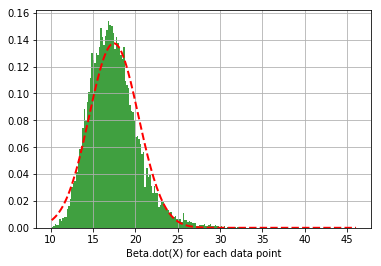

In [25]:
from scipy.stats import norm
n, bins, patches = plt.hist(d, 200, density=True, 
                            facecolor='g', alpha=0.75)
#plt.axis([10, 35, 0.0, 0.175])
plt.grid(True)
plt.xlabel('Beta.dot(X) for each data point')
(mu,sig) = norm.fit(d)
y = mlab.normpdf(bins, mu, sig)
l = plt.plot(bins, y, 'r--', linewidth=2)
print('Mu,sigma = %1.3f, %1.3f' % (mu,sig))
plt.show()

In [26]:
def integrate(lo, hi, n, bins):
    integral = 0.0
    for idx in range(lo,hi):
        integral += n[idx] * (bins[idx+1]-bins[idx])
    return integral

In [27]:
xvals, yvals, dx = [],[],[]
for idx in range(0,len(n)):
    integral = integrate(0, idx, n, bins)
    binpos =  0.5*(bins[idx+1] + bins[idx])
    dx.append(bins[idx+1] - bins[idx])
    xvals.append(binpos)
    yvals.append(integral)

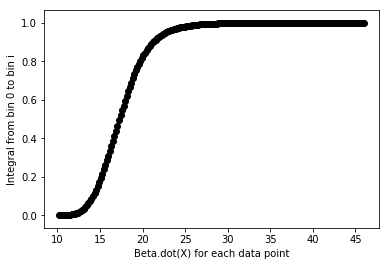

In [28]:
plt.scatter(xvals,yvals,color='black')
plt.xlabel('Beta.dot(X) for each data point')
plt.ylabel('Integral from bin 0 to bin i')
plt.show()

In [29]:
# save the betas
beta.to_csv('inputs/{0}/beta_{0}.csv'.format(race_type),sep=',', 
            index=False, header=False)

In [83]:
# Write out the integral plot
f = open('inputs/{0}/d_dist_{0}.csv'.format(race_type), 'w')
f.write('bin,xval,yval,dx\n')
for idx in range(0,len(xvals)):
    f.write('%d,%1.5f,%1.5f,%1.5f\n' % (idx,xvals[idx],yvals[idx], dx[idx]))
f.close()

In [31]:
# Write out the averaged time bands
for xrow in [subdf]:
    xrow['sex'] = xrow['sex'].map( {'W': 1, 'M': 2} ).astype(int)
    xrow['age_group'] = xrow['age_group'].map( age_map )
subdf.to_csv('inputs/{0}/avg_times_{0}.csv'.format(race_type),sep=',',
            index=False)

In [32]:
# Write out the GPX information used
gpx.to_csv('inputs/{0}/gpx_info_{0}.csv'.format(race_type),sep=',', index=False)

In [33]:
# Print out age and sex map
f1 = open('inputs/{0}/age_map_{0}.csv'.format(race_type), 'w')
for key, val in age_map.items():
    f1.write('%s,%d\n'%(key,val))
f1.close()

In [86]:
# Print out the event list
f2 = open('inputs/{0}/event_title_list_{0}.csv'.format(race_type), 'w')
f2.write('event\n')
for key, val in event_map.items():
    f2.write('%s\n'%key)
f2.close()

In [19]:
f3 = open('inputs/{0}/event_title_list_v2_{0}.csv'.format(race_type), 'w')
f3.write('ID,event\n')
for key, val in temp.items():
    f3.write('%d,%s\n'%(key,val))
f3.close()

In [21]:
input_dir = '/home/freddy/insight/letsdothis/inputs/'
input_evts  = race_type + '/event_title_list_v2_' + race_type + '.csv'
events_df = pd.read_csv(input_dir+input_evts)
events = dict(zip(events_df.ID,events_df.event))

In [22]:
events

{223524: 'Draycote Water Winter 10K Series',
 223537: 'QEOP Winter 10K Series',
 223538: 'QEOP Winter 10K Series',
 232067: 'Self Transcendence 10K',
 236203: 'EHH Boxing Day 10K',
 239334: 'Garstang 10K',
 254490: 'Ribble Valley 10K',
 256518: "Mornington Chasers Regent's Park 10K Winter Series",
 256519: "Mornington Chasers Regent's Park 10K Winter Series",
 264097: '3-1-5 Lancaster 5K / 10K Series',
 264158: 'Percy Pud 10K',
 264161: 'Skegness Coasters 10K',
 264168: 'Bromham Pudding Run 10K',
 264171: 'Hoad Hill Harriers Christmas Pudding 10K',
 264180: 'Andy Reading 10K',
 264183: 'Telford 10K',
 265296: 'Beith Harriers New Year Races',
 265337: 'Seeley Cup 10K',
 266392: 'Waterside 10K',
 266394: 'Gravesend Santa Dash 5K / 10K',
 267471: 'Greenwich Park Winter 10K Series',
 268552: "Serpentine New Year's Day 10K",
 268553: "Wymondham AC New Year's Day 10K",
 268554: "Wye Valley Runners New Year's Day 10K",
 268626: 'Woodcote 10K',
 268629: 'Stoke Stampede 10K',
 270817: 'Royal Pa